In [3]:
# import chemiscope
# import skmatter
import numpy as np
import matplotlib.pyplot as plt
import ast
from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations
from itertools import product
from equistore_utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from equistore_utils.clebsh_gordan import ClebschGordanReal
import ase.io as aseio

## Loads structures

In [5]:
frames = aseio.read("/Users/jigyasa/scratch/bispectrum_counter/boron/boron_8000_pbeccpvdz.xyz", ":")

## Computes expansion coefficients

In [7]:
operations.slice?

In [8]:
hypers = {
    "cutoff": 2.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, axis = "samples", labels=Labels(['center'],np.array([[0]], np.int32)) )
norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm_rho1

In [11]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, axis="samples", labels=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
for b in gij.blocks():
    b.values[:]/=norm_rho1

## Triplet descriptors

In [12]:
cg = ClebschGordanReal(5)

In [13]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)


KeyboardInterrupt



In [14]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

Exception ignored in: <function Labels.__del__ at 0x132a127a0>
Traceback (most recent call last):
  File "/Users/jigyasa/miniconda3/lib/python3.10/site-packages/equistore/core/labels.py", line 146, in __del__
    self._lib.eqs_labels_free(self._eqs_labels_t)
  File "/Users/jigyasa/miniconda3/lib/python3.10/site-packages/equistore/core/status.py", line 28, in _check_status
    def _check_status(status):
KeyboardInterrupt: 


NameError: name 'rhoii1i2_nu0' is not defined

Now contract descriptors to make things faster

In [15]:
from sklearn.decomposition import PCA


KeyboardInterrupt



In [ ]:
%%time
raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(),rhoii1i2_nu1.block(1).values.squeeze()])
feats_n2nu1 = PCA(n_components=min(raw.shape[0],raw.shape[-1])//4).fit_transform(raw)/ np.sqrt((raw**2).sum(axis=1).mean())

In [ ]:
rhoii1i2_nu0 = None; rhoii1i2_nu1 = None;

compute squares and re-contract

In [ ]:
%%time
feats_n3 = feats_n2nu1.reshape(8000,64,-1).sum(axis=1)

In [ ]:
%%time
feats_n2nu1_2 = np.einsum('ija,ijb->iab', feats_n2nu1.reshape(8000,64,-1), feats_n2nu1.reshape(8000,64,-1)).reshape(8000,-1)

In [26]:
from skmatter.decomposition import PCovR
from skmatter.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import Ridge

In [20]:
e0 = -198.11364281310415
energy = np.array([27.211386*(f.info['energy_ha']-e0) for f in frames])

In [102]:
frames[0].info

{'energy_ha': -197.8044024219673,
 'label': 0,
 'basis': 'ccpvdz',
 'xc': 'pbe',
 'pars': "(0, '+', 1.3945490156290707, 0.5779363176538004, 1.7685268584161764, 2.2879156819735713, 2.6660340954713644, 1.8331788801509368)"}

In [103]:
X_scaler = StandardFlexibleScaler()
X_scaled = X_scaler.fit_transform(feats_n2nu1_2)

y_scaler = StandardFlexibleScaler()
y_scaled = y_scaler.fit_transform(energy.reshape(-1,1))

In [104]:
pcovr = PCovR(mixing=0.5,
              regressor=Ridge(alpha=1E-8, fit_intercept=False, tol=1E-12),
              n_components=2)

In [105]:
T = pcovr.fit_transform(X_scaled, y_scaled)

In [122]:
ypred_n3 = Ridge(alpha=1e-8).fit(feats_n3, energy).predict(feats_n3)

In [123]:
ypred = Ridge(alpha=1e-8).fit(X_scaled, energy).predict(X_scaled)

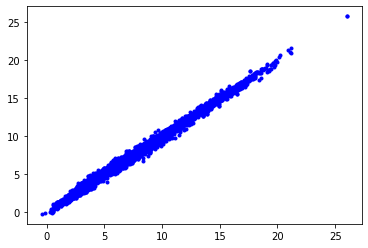

In [124]:
plt.plot(energy, ypred,'b.')

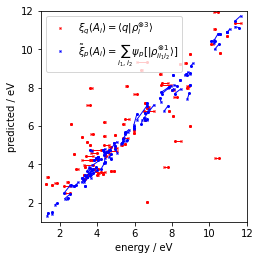

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3.5), constrained_layout=True)
ax.plot(np.vstack([energy[:200:2],energy[1:200:2]]), np.vstack([ypred_n3[:200:2],ypred_n3[1:200:2]]),'r-', lw=1);
ax.plot(energy[:200:2],ypred_n3[:200:2],'r',ls="",marker='x',markersize=2, label=r"$\xi_q(A_i)=\langle q|\rho_i^{\otimes{3}}\rangle$");
ax.plot(energy[1:200:2],ypred_n3[1:200:2],'r',ls="",marker='o',markersize=2);
ax.plot(np.vstack([energy[:200:2],energy[1:200:2]]), np.vstack([ypred[:200:2],ypred[1:200:2]]),'b-', lw=1);
ax.plot(energy[0:200:2],ypred[0:200:2],'b',ls="",marker='x',markersize=2, label=r"$\tilde{\xi}_p(A_i) =\sum_{i_1,i_2}\psi_p[|\rho_{ii_1 i_2}^{\otimes{1}}\rangle]$");
ax.plot(energy[1:200:2],ypred[1:200:2],'b',ls="",marker='o',markersize=2);
ax.set_xlim(1,12)
ax.set_ylim(1,12)
ax.set_xlabel('energy / eV')
ax.set_ylabel('predicted / eV')
ax.legend()
fig.savefig("/tmp/pair_stuff.svg")

In [115]:
cs=chemiscope.show(frames=frames, properties={"PCovR[1]" : T[:,0], "PCovR[2]" : T[:,1], "energy/eV" :energy, "pair_id": [ast.literal_eval(f.info['pars'])[1] for f in frames]},
                  settings={'map': {'x': {'max': 3.9222807923514678,    'min': -1.7918320583142955,   'property': 'PCovR[1]',   'scale': 'linear'},
  'y': {'max': 1.5695223016140076,   'min': -1.2764482528170318,   'property': 'PCovR[2]',   'scale': 'linear'},
  'z': {'max': 0, 'min': 0, 'property': '', 'scale': 'linear'},  'color': {'max': 25.97947119556587,   'min': -0.38104196321398304,   'property': 'energy/eV',   'scale': 'linear'},
  'symbol': 'pair_id',  'palette': 'inferno',  'size': {'factor': 30, 'mode': 'linear', 'property': '', 'reverse': False}}})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"map": {"x": {"max": 3.9222807923514678, "min": -…

In [111]:
cs.settings

{'map': {'x': {'max': 3.9222807923514678,
   'min': -1.7918320583142955,
   'property': 'PCovR[1]',
   'scale': 'linear'},
  'y': {'max': 1.5695223016140076,
   'min': -1.2764482528170318,
   'property': 'PCovR[2]',
   'scale': 'linear'},
  'z': {'max': 0, 'min': 0, 'property': '', 'scale': 'linear'},
  'color': {'max': 25.97947119556587,
   'min': -0.38104196321398304,
   'property': 'energy/eV',
   'scale': 'linear'},
  'symbol': '',
  'palette': 'inferno',
  'size': {'factor': 50, 'mode': 'linear', 'property': '', 'reverse': False}},
 'structure': [{'bonds': True,
   'spaceFilling': False,
   'atomLabels': False,
   'unitCell': False,
   'rotation': False,
   'supercell': {'0': 1, '1': 1, '2': 1},
   'axes': 'off',
   'keepOrientation': False,
   'playbackDelay': 700,
   'environments': {'activated': True,
    'bgColor': 'grey',
    'bgStyle': 'ball-stick',
    'center': False,
    'cutoff': 0}}]}